User Stories Classification with Roberta 

In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
from torch.optim import Adam
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

#read all data files ,load the model and tokenizer
df = pd.read_csv('dataset/user_stories_data.csv')
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }


#dataset 
class Dataset(Dataset):
    def __init__(self,df):
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt")
                      for text in df['texts']]
        self.labels = [labels[label] for label in df['labels']]


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        text = self.texts[idx]  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text,label
       
#classifier
from transformers import RobertaModel
import torch.nn as nn

class RobertaClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        #add a linear layer to do classification
        self.linear = nn.Linear(768, 8)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        outputs = self.roberta(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

# fine-tune the model
def train(model,train_data,val_data,learning_rate,epochs):
    
    train,val = Dataset(train_data),Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr = learning_rate)
    schedular = ExponentialLR(optimizer,gamma=0.95)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input,train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            print(
                f'''Epochs: {epoch_num + 1}
              | Train Loss: {total_loss_train / len(train_data): .3f}
              | Train Accuracy: {total_acc_train / len(train_data): .3f}
              | Val Loss: {total_loss_val / len(val_data): .3f}
              | Val Accuracy: {total_acc_val / len(val_data): .3f}''')
        schedular.step()

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

EPOCHS = 10
model = RobertaClassifier(dropout=0.1)
LR = 1e-5
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
train(model, df_train, df_val, LR, EPOCHS)    



#evaluate
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
        
    model.eval()
    correct_pred = {label:0 for label in labels.values()}
    total_label = {label:0 for label in labels.values()}
    total_pred = {label:0 for label in labels.values()}
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              preds = output.argmax(dim=1)
              for label,pred in zip(test_label,preds):
                  total_label[label.item()] += 1 # total sample of this label is counted
                  total_pred[pred.item()] +=1 # total predcit labels 
                  if label == pred:
                      correct_pred[label.item()] += 1 # True positive 
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    for label, correct_count in correct_pred.items(): 
        recall = 100 * correct_count / total_label[label] if total_label[label] > 0 else 0
        print(f'Recall for label {label}: {recall:.2f}%')
        precision = 100 * correct_count / total_pred[label] if total_pred[label] > 0 else 0
        print(f'Precision for label {label}: {precision:.2f}%')
        F1_score = 2 * (precision * recall)/(precision + recall)
        print(f'F1 for label {label}: {F1_score:.2f}')
evaluate(model, df_test)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:16<00:00,  6.41it/s]


Epochs: 1
              | Train Loss:  0.554
              | Train Accuracy:  0.588
              | Val Loss:  0.402
              | Val Accuracy:  0.732


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:18<00:00,  6.34it/s]


Epochs: 2
              | Train Loss:  0.283
              | Train Accuracy:  0.807
              | Val Loss:  0.344
              | Val Accuracy:  0.758


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:20<00:00,  6.28it/s]


Epochs: 3
              | Train Loss:  0.171
              | Train Accuracy:  0.887
              | Val Loss:  0.349
              | Val Accuracy:  0.780


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:25<00:00,  6.13it/s]


Epochs: 4
              | Train Loss:  0.118
              | Train Accuracy:  0.921
              | Val Loss:  0.343
              | Val Accuracy:  0.793


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:19<00:00,  6.29it/s]


Epochs: 5
              | Train Loss:  0.086
              | Train Accuracy:  0.934
              | Val Loss:  0.368
              | Val Accuracy:  0.783


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:19<00:00,  6.29it/s]


Epochs: 6
              | Train Loss:  0.070
              | Train Accuracy:  0.940
              | Val Loss:  0.388
              | Val Accuracy:  0.790


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:19<00:00,  6.30it/s]


Epochs: 7
              | Train Loss:  0.058
              | Train Accuracy:  0.943
              | Val Loss:  0.388
              | Val Accuracy:  0.790


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:20<00:00,  6.27it/s]


Epochs: 8
              | Train Loss:  0.050
              | Train Accuracy:  0.945
              | Val Loss:  0.411
              | Val Accuracy:  0.783


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:19<00:00,  6.29it/s]


Epochs: 9
              | Train Loss:  0.047
              | Train Accuracy:  0.948
              | Val Loss:  0.450
              | Val Accuracy:  0.771


100%|██████████████████████████████████████████████████████████████████████████████| 1257/1257 [03:21<00:00,  6.23it/s]


Epochs: 10
              | Train Loss:  0.042
              | Train Accuracy:  0.947
              | Val Loss:  0.455
              | Val Accuracy:  0.783
Test Accuracy:  0.765
Recall for label 0: 66.28%
Precision for label 0: 67.86%
F1 for label 0: 67.06
Recall for label 1: 77.67%
Precision for label 1: 73.39%
F1 for label 1: 75.47
Recall for label 2: 47.62%
Precision for label 2: 62.50%
F1 for label 2: 54.05
Recall for label 3: 84.21%
Precision for label 3: 84.21%
F1 for label 3: 84.21
Recall for label 4: 100.00%
Precision for label 4: 100.00%
F1 for label 4: 100.00
Recall for label 5: 92.31%
Precision for label 5: 85.71%
F1 for label 5: 88.89
Recall for label 6: 100.00%
Precision for label 6: 100.00%
F1 for label 6: 100.00
Recall for label 7: 73.33%
Precision for label 7: 73.33%
F1 for label 7: 73.33


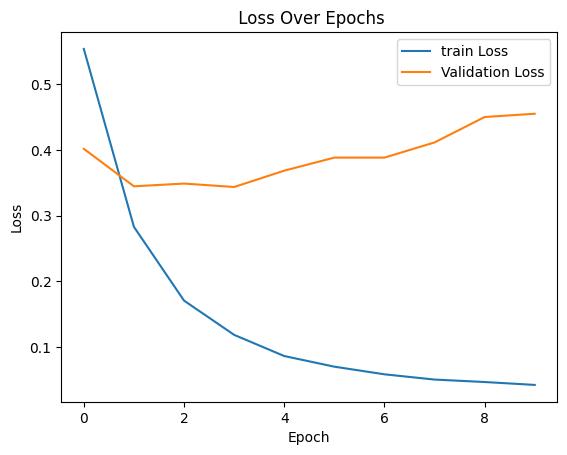

In [2]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss Over Epochs')
plt.legend()
plt.show()

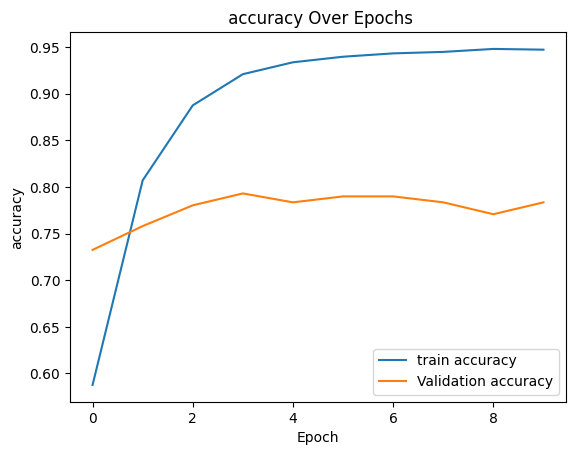

In [3]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title(' accuracy Over Epochs')
plt.legend()
plt.show()